# To-do: 
- continue updating stop words with host names, etc.
- add a narrative around/context behind each of our analysis choices below
- double check the PMI calculations (does it make sense that they are all equal to one another?). i think it does make sense, especially at the transcript level - many words will probably only ever co-occur with covid and never occur on their own, and so they get the same PMI? 

# Setup

## Update Stop Words
Add host names and other words to set of English stop words to exclude from analysis

In [1]:
from sklearn.feature_extraction import text

#text.ENGLISH_STOP_WORDS

In [2]:
# add host names, etc
add_stop_words = ['anderson', 'cooper', 'rachel', 'maddow', 
                  'chris', 'hayes', 'ari', 'berman', 'michael', 'osterholm',
                  'cnn', 'msnbc', 'cnns', 'msnbcs',
                  'vivek', 'murthy', 'rochelle', 'walensky', 'jerome', 'adams', 'alex', 'azar',
                  'anthony', 'fauci', 'faucis',
                  'cuomo', 'erin', 'david',
                  'leana', 'wen', 'deborah', 'birx',
                  'robert', 'redfield', 'gavin', 'newsom',
                  'ashish', 'jha', 'tom', 'frieden',
                  'video', 'clip', 'voiceover', 'videotape']

In [3]:
# add stop words to English set
full_stop_words = text.ENGLISH_STOP_WORDS.union(add_stop_words)

## Define COVID terms
Define groups of terms referring to COVID, vaccines, masks

In [4]:
# covid terms
covid_terms = ['coronavirus', 'covid', 'covid-19', 'covid-', 'covid19', 'virus']

In [5]:
# vaccine terms
vaccine_terms = ['vaccine', 'vaccination', 'vaccinated', 'vaccinated', 'mrna', 'booster', 'vax', 'vaxx', 'vaxxed']

In [6]:
# mask terms
mask_terms = ['mask', 'masking']

# Load Data

## Read in the total list of data files

In [7]:
#import libraries
import glob 
import os
import matplotlib.pyplot as plt
import numpy as np
import string
import regex as re

# get a list of file names to read into the dataset
repo_path = os.path.dirname(os.getcwd()) #get the correct file path 
rm_paths = glob.glob(repo_path + "/data/01-raw/rachel_maddow/*.txt") #the paths for the rachel maddow transcript files
ac_paths = glob.glob(repo_path + "/data/01-raw/anderson_cooper/*.txt") #the paths for the anderson cooper transcript files

all_liberal_files = rm_paths + ac_paths

## Read files, clean text, store cleaned transcripts and sentences

In [8]:
text_transcripts = [] # container for transcript text
text_sentences = [] # container for sentence text
covid_counts_transcripts = [] # container for transcript covid mention counts
covid_counts_sentences = [] # container for sentence covid mention counts

# read in each transcript, do text cleaning, add text and counts to containers
# split sentences on periods, do text cleaning, add text and counts to containers
# text cleaning is done separately for transcripts and sentences to help split sentences better

#### transcripts as documents
for transcript in all_liberal_files:
    
    # create transcript covid counter
    cov_trans_counter = 0
    
    # read text
    text = open(transcript, encoding = 'utf-8').read().lower()
    
    ### string cleaning
    # line below replaces periods with spaces because spaces after periods are often missing, then strips extra spaces
    corpus_text = text.replace('\xa0', '').replace('.', ' ').replace('  ', ' ')
    # remove all punctuation
    for c in string.punctuation:
        corpus_text = corpus_text.replace(c, "")
    # remove numbers
    corpus_text = re.sub('\d+', '', corpus_text)
    # remove whitespaces
    corpus_text = " ".join(corpus_text.split())
    
    # add cleaned text to container
    text_transcripts.append(corpus_text)
    
    # add to counter if word in text is in covid terms, add count to container
    for word in corpus_text.split(' '):
        if word in covid_terms:
            cov_trans_counter += 1
    covid_counts_transcripts.append(cov_trans_counter)
    
    
    #### sentences as documents
    for sentence in text.split('.'): # note that splitting on periods is not perfect for identifying sentences
        
        # create sentence covid counter
        cov_sen_counter = 0
        
        ### string cleaning
        corpus_sen = sentence.replace('\xa0', '')
        # remove all punctuation    
        for c in string.punctuation:
            corpus_sen = corpus_sen.replace(c, "")
        # remove numbers            
        corpus_sen = re.sub('\d+', '', corpus_sen)
        # remove whitespaces
        corpus_sen = " ".join(corpus_sen.split())
        
        # add cleaned sentence to container
        text_sentences.append(corpus_sen)
        
        # add to counter if word in sentence is in covid terms, add count to container
        for word in corpus_sen.split(' '):
            if word in covid_terms:
                cov_sen_counter += 1
        covid_counts_sentences.append(cov_sen_counter)  

In [9]:
# display simple counts
print("Our liberal news corpus consists of {:,} total transcripts, sourced from Anderson Cooper 360 and the Rachel Maddow Show.".format(len(text_transcripts)))

print("There are {:,} total sentences in the corpus.".format(len(text_sentences)))

print("There are {:,} transcripts that mention COVID at least once.".format(len(text_transcripts) - covid_counts_transcripts.count(0)))

Our liberal news corpus consists of 1,008 total transcripts, sourced from Anderson Cooper 360 and the Rachel Maddow Show.
There are 459,365 total sentences in the corpus.
There are 876 transcripts that mention COVID at least once.


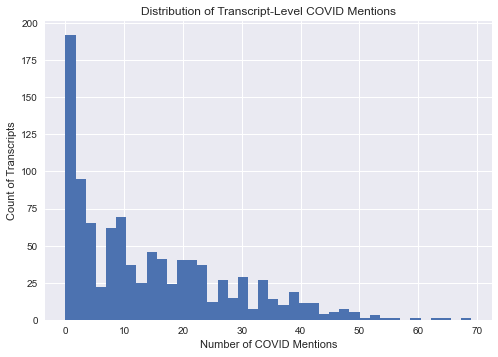

In [10]:
# Distribution of COVID mentions - transcripts
plt.style.use('seaborn')  

plt.hist(covid_counts_transcripts, bins = 40)
plt.xlabel('Number of COVID Mentions')
plt.ylabel('Count of Transcripts')
plt.title('Distribution of Transcript-Level COVID Mentions')

plt.show()

## Data Pre-Processing

### Spacy Implementation & Removal of Stop Words 
This analysis is useful if we want more control over the corpus of stop words that are used in our analysis

In [11]:
#Compare spacy implemtation to the sklearn #loads spacy and turns off some aspects 
# import spacy
# nlp = spacy.load('en_core_web_sm', disable=['ner', 'parser'])


# Word-Frequency Analysis

## Use CountVectorizer to get the unique vocabulary list and eliminate stop words

In [12]:
from sklearn.feature_extraction.text import CountVectorizer
from operator import itemgetter

In [13]:
# set up count vectorizer function
def countvec(text_list):
    
    # step 1: set up the vectorizer
    vectorizer = CountVectorizer(min_df = 30, 
                                 stop_words = full_stop_words, 
                                 max_df = 0.8)
    
    # step 2: apply the vectorizer to the corpus of documents and store in document matrix X
    X = vectorizer.fit(text_list)
    
    # step 3: fit transform corpus of documents
    X_transformed = vectorizer.fit_transform(text_list)
    
    # step 4: extract feature names and counts, create dictionary
    array_of_words = vectorizer.get_feature_names_out()
    array_of_counts = X_transformed.toarray().sum(axis = 0)
    word_frequency_dictionary = dict(zip(array_of_words, array_of_counts))
    
    return(X, X_transformed, array_of_words, array_of_counts, word_frequency_dictionary)

## Apply CountVectorizer and Plot Top Words
Note: need to double-check how the counts are arrived at - is it by document or number of occurences in a given document?

### Full Transcript Set

In [14]:
# apply function to full transcript set
X_trans, X_transformed_trans, array_of_words_trans, array_of_counts_trans, word_frequency_dictionary_trans = countvec(text_transcripts)

In [15]:
# vocabulary length
print("There are {:,} unique words in the vocabulary.".format(len(X_trans.vocabulary_)))

There are 6,963 unique words in the vocabulary.


In [16]:
#check to see if "coronavirus" is in the dictionary, print index value
vocab = X_trans.vocabulary_

vocab['coronavirus']

1392

In [17]:
# set number of top words to see
num_top_words = 10

top_10_words = dict(sorted(word_frequency_dictionary_trans.items(), key = itemgetter(1), reverse = True)[:num_top_words])

print(top_10_words)

{'republicans': 6011, 'dr': 5686, 'police': 5514, 'health': 5366, 'vote': 5239, 'justice': 5228, 'court': 5171, 'vaccine': 5035, 'senate': 4960, 'department': 4889}


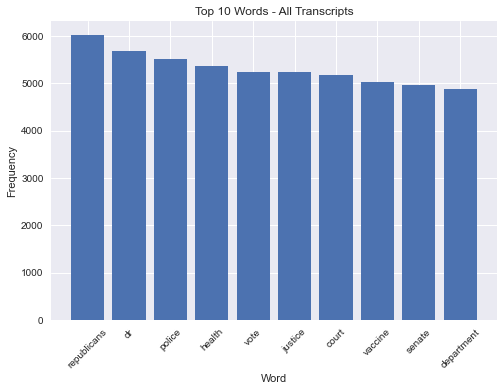

In [18]:
# plot top words
plt.style.use('seaborn')  

x = top_10_words.keys()
y = top_10_words.values()
plt.bar(x,y)
plt.xlabel('Word')
plt.xticks(rotation=45)
plt.ylabel('Frequency')
plt.title('Top 10 Words - All Transcripts')

plt.show()

### Restricted Transcript Set - Nonzero COVID Mentions

In [19]:
# create a restricted transcript list including only transcripts that mention a COVID term at least one
text_trans_cov = [text_transcripts[i] for i in range(len(text_transcripts)) if covid_counts_transcripts[i] > 0]

In [20]:
# apply function to restricted list
X_trans_cov, X_transformed_trans_cov, array_of_words_trans_cov, array_of_counts_trans_cov, word_frequency_dictionary_trans_cov = countvec(text_trans_cov)

In [21]:
# vocabulary length
print("There are {:,} unique words in the vocabulary.".format(len(X_trans_cov.vocabulary_)))

There are 6,313 unique words in the vocabulary.


In [22]:
# check to see if "coronavirus" is in the dictionary, print index
vocab = X_trans_cov.vocabulary_

vocab['coronavirus']

1261

In [23]:
# set the number of top words to see
num_top_words = 10

top_10_words = dict(sorted(word_frequency_dictionary_trans_cov.items(), key = itemgetter(1), reverse = True)[:num_top_words])

print(top_10_words)

{'dr': 5653, 'republicans': 5121, 'vaccine': 5020, 'police': 4688, 'vote': 4474, 'senate': 4279, 'justice': 4139, 'court': 4123, 'department': 4075, 'senator': 3904}


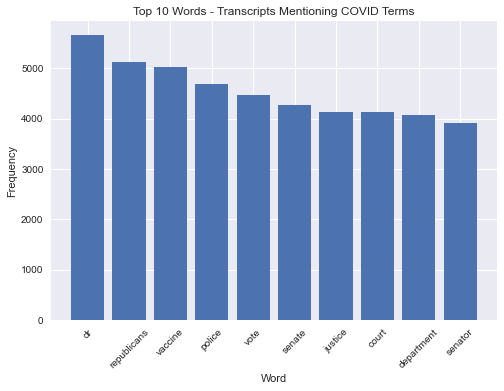

In [24]:
# plot top words
plt.style.use('seaborn')  

x = top_10_words.keys()
y = top_10_words.values()
plt.bar(x,y)
plt.xlabel('Word')
plt.xticks(rotation=45)
plt.ylabel('Frequency')
plt.title('Top 10 Words - Transcripts Mentioning COVID Terms')

plt.show()

### Full Sentence Set

In [25]:
# apply function to sentences
X_sen, X_transformed_sen, array_of_words_sen, array_of_counts_sen, word_frequency_dictionary_sen = countvec(text_sentences)

In [26]:
# vocabulary length
print("There are {:,} unique words in the vocabulary.".format(len(X_sen.vocabulary_)))

There are 8,764 unique words in the vocabulary.


In [27]:
#check to see if "coronavirus" is in the dictionary, print index
vocab = X_sen.vocabulary_

vocab['coronavirus']

1756

In [28]:
#set the number of top words to see
num_top_words = 10

top_10_words = dict(sorted(word_frequency_dictionary_sen.items(), key = itemgetter(1), reverse = True)[:num_top_words])

print(top_10_words)

{'know': 40497, 'people': 33183, 'president': 31884, 'just': 31780, 'going': 29587, 'think': 23519, 'right': 20509, 'thats': 19676, 'like': 19458, 'trump': 19417}


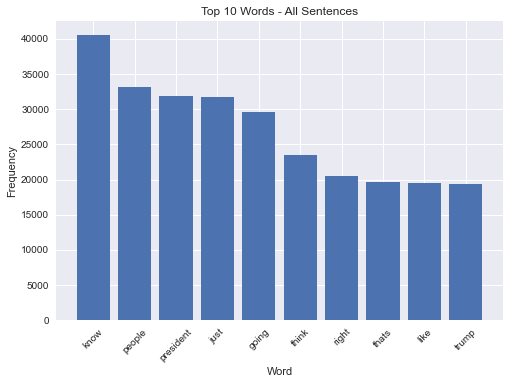

In [29]:
# plot top words
plt.style.use('seaborn')  

x = top_10_words.keys()
y = top_10_words.values()
plt.bar(x,y)
plt.xlabel('Word')
plt.xticks(rotation=45)
plt.ylabel('Frequency')
plt.title('Top 10 Words - All Sentences')

plt.show()

### Restricted Sentence Set - Nonzero COVID Mentions

In [30]:
# create a restricted transcript list including only transcripts that mention a COVID term at least once
text_sen_cov = [text_sentences[i] for i in range(len(text_sentences)) if covid_counts_sentences[i] > 0]

In [31]:
# apply function to restricted list
X_sen_cov, X_transformed_sen_cov, array_of_words_sen_cov, array_of_counts_sen_cov, word_frequency_dictionary_sen_cov = countvec(text_sen_cov)

In [32]:
# vocabulary length
print("There are {:,} unique words in the vocabulary.".format(len(X_sen_cov.vocabulary_)))

There are 930 unique words in the vocabulary.


In [33]:
# check to see if "coronavirus" is in the dictionary, print index
vocab = X_sen_cov.vocabulary_

vocab['coronavirus']

150

In [34]:
# set the number of top words to see
num_top_words = 10

top_10_words = dict(sorted(word_frequency_dictionary_sen_cov.items(), key = itemgetter(1), reverse = True)[:num_top_words])

print(top_10_words)

{'covid': 6927, 'coronavirus': 3777, 'virus': 3697, 'people': 2151, 'president': 1622, 'know': 1528, 'just': 1384, 'new': 1281, 'going': 1097, 'today': 871}


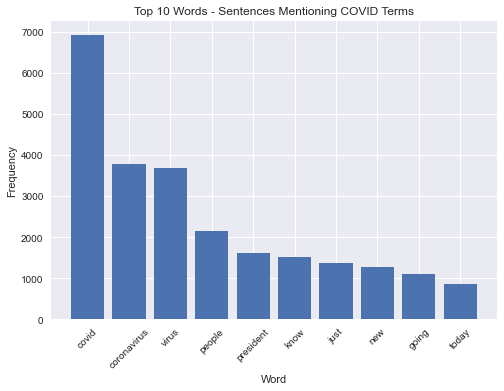

In [35]:
# plot top words
plt.style.use('seaborn')  

x = top_10_words.keys()
y = top_10_words.values()
plt.bar(x,y)
plt.xlabel('Word')
plt.xticks(rotation=45)
plt.ylabel('Frequency')
plt.title('Top 10 Words - Sentences Mentioning COVID Terms')

plt.show()

# Co-Occurrence Analysis

- appearance anywhere in a document increases count by 1
- tried doing frequencies instead, but was running into problems
- done separately for both transcripts and sentences
- done separately for COVID terms, mask terms, vaccine terms
- printed out two types of lists for each: (1) the top words based on PMI only (2) the top words (by PMI), given that the word appears at least X times in the corpus. thoughts?

In [36]:
from collections import Counter
import spacy

## Transcript-Level Co-Occurrence

In [37]:
# instantiate nlp
nlp = spacy.load('en_core_web_sm', disable = ['ner', 'parser'])

In [38]:
%%time
# nlp parse transcripts
nlp_list_trans = [nlp(text) for text in text_transcripts]

CPU times: total: 8min
Wall time: 8min 1s


In [39]:
# create counters
lemma_counter = Counter()
covid_co_counter = Counter()
covid_count = 0
mask_co_counter = Counter()
mask_count = 0
vaccine_co_counter = Counter()
vaccine_count = 0

# for each document, add unique lemmas to counter
# increase co-occurrence and covid counter if covid terms overlap lemma set
# same for mask terms, vaccine terms
for transcript in nlp_list_trans:
    lemmas = {token.lemma_.lower() for token in transcript}
    lemma_counter.update(lemmas)
    if not lemmas.isdisjoint(set(covid_terms)):
        covid_co_counter.update(lemmas)
        covid_count += 1
    if not lemmas.isdisjoint(set(mask_terms)):
        mask_co_counter.update(lemmas)
        mask_count += 1
    if not lemmas.isdisjoint(set(vaccine_terms)):
        vaccine_co_counter.update(lemmas)
        vaccine_count += 1

In [40]:
# calculate COVID terms PMI
# P(covid)
covid_ratio = covid_count / len(nlp_list_trans)

# calculate PMI only for words that co-occur
pmi_covid = list()
for lemma, count in covid_co_counter.items():
    
    lemma_ratio = lemma_counter[lemma] / len(nlp_list_trans) # P(lemma)
    co_ratio = covid_co_counter[lemma] / len(nlp_list_trans) # P(covid, lemma)
    
    # store lemma, total lemma count, co-occur count, and PMI
    pmi_covid += [(lemma, lemma_counter[lemma], covid_co_counter[lemma], 
                   np.log2(co_ratio / (covid_ratio * lemma_ratio)))]

# sort list of tuples by pmi then by lemma count, descending
pmi_covid_sort = sorted(pmi_covid, key = lambda x: [round(x[3], 5), x[1]], reverse = True)

In [41]:
# calculate mask terms PMI
# P(mask)
mask_ratio = mask_count / len(nlp_list_trans)

# calculate PMI only for words that co-occur
pmi_mask = list()
for lemma, count in mask_co_counter.items():
    
    lemma_ratio = lemma_counter[lemma] / len(nlp_list_trans) # P(lemma)
    co_ratio = mask_co_counter[lemma] / len(nlp_list_trans) # P(mask, lemma)
    
    # store lemma, total lemma count, co-occur count, and PMI
    pmi_mask += [(lemma, lemma_counter[lemma], mask_co_counter[lemma], 
                   np.log2(co_ratio / (mask_ratio * lemma_ratio)))]

# sort list of tuples by pmi then by lemma count, descending
pmi_mask_sort = sorted(pmi_mask, key = lambda x: [round(x[3], 5), x[1]], reverse = True)

In [42]:
# calculate vaccine terms PMI
# P(vaccine)
vaccine_ratio = vaccine_count / len(nlp_list_trans)

# calculate PMI only for words that co-occur
pmi_vaccine = list()
for lemma, count in vaccine_co_counter.items():
    
    lemma_ratio = lemma_counter[lemma] / len(nlp_list_trans) # P(lemma)
    co_ratio = vaccine_co_counter[lemma] / len(nlp_list_trans) # P(vaccine, lemma)
    
    # store lemma, total lemma count, co-occur count, and PMI
    pmi_vaccine += [(lemma, lemma_counter[lemma], vaccine_co_counter[lemma], 
                   np.log2(co_ratio / (vaccine_ratio * lemma_ratio)))]

# sort list of tuples by pmi then by lemma count, descending
pmi_vaccine_sort = sorted(pmi_vaccine, key = lambda x: [round(x[3], 5), x[1]], reverse = True)

In [43]:
# print top 100 words (by PMI) that co-occur with COVID terms
counter = 0
print('{:<25} {:<15} {:<15} {:<15}'.format('Word', 'Word Count', 'Co-Occur Count', 'PMI'))
print('-' * 70)
for lemma in pmi_covid_sort:
    if (lemma[0] not in full_stop_words) and (lemma[0] not in covid_terms) and (counter < 100):
        print('{:<25} {:<15} {:<15} {:<15}'.format(lemma[0], lemma[1], lemma[2], round(lemma[3], 5)))
        counter += 1

Word                      Word Count      Co-Occur Count  PMI            
----------------------------------------------------------------------
infection                 432             432             0.20249        
symptom                   263             263             0.20249        
epidemic                  241             241             0.20249        
variant                   232             232             0.20249        
icu                       217             217             0.20249        
indoor                    185             185             0.20249        
ventilator                175             175             0.20249        
antibody                  152             152             0.20249        
unvaccinated              136             136             0.20249        
contagious                130             130             0.20249        
ppe                       124             124             0.20249        
asymptomatic              99             

In [44]:
# print top 100 words (by PMI) that co-occur with COVID terms given that lemma count > 300
counter = 0
print('{:<25} {:<15} {:<15} {:<15}'.format('Word', 'Word Count', 'Co-Occur Count', 'PMI'))
print('-' * 70)
for lemma in pmi_covid_sort:
    if (lemma[0] not in full_stop_words) and (lemma[0] not in covid_terms) and (counter < 100) and (lemma[1] > 300):
        print('{:<25} {:<15} {:<15} {:<15}'.format(lemma[0], lemma[1], lemma[2], round(lemma[3], 5)))
        counter += 1

Word                      Word Count      Co-Occur Count  PMI            
----------------------------------------------------------------------
infection                 432             432             0.20249        
hospitalization           355             354             0.19842        
cdc                       382             380             0.19492        
infect                    405             402             0.19177        
testing                   376             372             0.18706        
disease                   464             459             0.18686        
vaccine                   619             610             0.18136        
vaccination               320             315             0.17977        
dr                        659             645             0.17151        
sick                      448             437             0.16663        
surge                     359             350             0.16586        
science                   391            

In [45]:
# print top 100 words (by PMI) that co-occur with mask terms
counter = 0
print('{:<25} {:<15} {:<15} {:<15}'.format('Word', 'Word Count', 'Co-Occur Count', 'PMI'))
print('-' * 70)
for lemma in pmi_mask_sort:
    if (lemma[0] not in full_stop_words) and (lemma[0] not in mask_terms) and (counter < 100):
        print('{:<25} {:<15} {:<15} {:<15}'.format(lemma[0], lemma[1], lemma[2], round(lemma[3], 5)))
        counter += 1

Word                      Word Count      Co-Occur Count  PMI            
----------------------------------------------------------------------
antigen                   24              24              0.76783        
meatpacking               23              23              0.76783        
reuse                     22              22              0.76783        
remdesivir                21              21              0.76783        
ihme                      19              19              0.76783        
floridian                 19              19              0.76783        
sebelius                  17              17              0.76783        
reagent                   16              16              0.76783        
stayat                    15              15              0.76783        
asthma                    15              15              0.76783        
facemask                  15              15              0.76783        
denmark                   14             

In [46]:
# print top 100 words (by PMI) that co-occur with mask terms given that lemma count > 300
counter = 0
print('{:<25} {:<15} {:<15} {:<15}'.format('Word', 'Word Count', 'Co-Occur Count', 'PMI'))
print('-' * 70)
for lemma in pmi_mask_sort:
    if (lemma[0] not in full_stop_words) and (lemma[0] not in mask_terms) and (counter < 100) and (lemma[1] > 300):
        print('{:<25} {:<15} {:<15} {:<15}'.format(lemma[0], lemma[1], lemma[2], round(lemma[3], 5)))
        counter += 1

Word                      Word Count      Co-Occur Count  PMI            
----------------------------------------------------------------------
testing                   376             319             0.53065        
infection                 432             350             0.46415        
wear                      611             484             0.43166        
infect                    405             319             0.42346        
disease                   464             364             0.41764        
hospitalization           355             278             0.41509        
patient                   432             338             0.41382        
virus                     582             454             0.4095         
science                   391             302             0.39521        
surge                     359             276             0.38851        
positive                  469             360             0.38624        
distance                  312            

In [47]:
# print top 100 words (by PMI) that co-occur with vaccine terms
counter = 0
print('{:<25} {:<15} {:<15} {:<15}'.format('Word', 'Word Count', 'Co-Occur Count', 'PMI'))
print('-' * 70)
for lemma in pmi_vaccine_sort:
    if (lemma[0] not in full_stop_words) and (lemma[0] not in vaccine_terms) and (counter < 100):
        print('{:<25} {:<15} {:<15} {:<15}'.format(lemma[0], lemma[1], lemma[2], round(lemma[3], 5)))
        counter += 1

Word                      Word Count      Co-Occur Count  PMI            
----------------------------------------------------------------------
pfizer                    216             216             0.65987        
moderna                   149             149             0.65987        
unvaccinated              136             136             0.65987        
transmissible             71              71              0.65987        
unvaccinate               66              66              0.65987        
jj                        44              44              0.65987        
placebo                   39              39              0.65987        
immunization              34              34              0.65987        
astrazeneca               31              31              0.65987        
immunocompromise          30              30              0.65987        
uptake                    23              23              0.65987        
transmissibility          22             

In [48]:
# print top 100 words (by PMI) that co-occur with vaccine terms given that lemma count > 300
counter = 0
print('{:<25} {:<15} {:<15} {:<15}'.format('Word', 'Word Count', 'Co-Occur Count', 'PMI'))
print('-' * 70)
for lemma in pmi_vaccine_sort:
    if (lemma[0] not in full_stop_words) and (lemma[0] not in vaccine_terms) and (counter < 100) and (lemma[1] > 300):
        print('{:<25} {:<15} {:<15} {:<15}'.format(lemma[0], lemma[1], lemma[2], round(lemma[3], 5)))
        counter += 1

Word                      Word Count      Co-Occur Count  PMI            
----------------------------------------------------------------------
vaccinate                 385             373             0.61418        
cdc                       382             308             0.34923        
hospitalization           355             285             0.34301        
disease                   464             369             0.32936        
infection                 432             343             0.32704        
science                   391             308             0.31563        
dr                        659             513             0.29855        
infect                    405             314             0.29271        
virus                     582             444             0.26941        
datum                     550             419             0.26739        
rate                      503             381             0.2591         
study                     418            

## Sentence-Level Co-Occurrence

In [49]:
# instantiate nlp
nlp = spacy.load('en_core_web_sm', disable = ['ner', 'parser'])

In [50]:
# split sentences into batches
text_sentences_batches = np.array_split(text_sentences, 10)

In [51]:
%%time
# nlp parse batches
nlp_list_sen = []
for batch in text_sentences_batches:
    print('working') # will print 10 times total
    for sentence in batch:
        nlp_list_sen.append(nlp(str(sentence)))

working
working
working
working
working
working
working
working
working
working
CPU times: total: 19min 51s
Wall time: 19min 53s


In [52]:
# create counters
lemma_counter = Counter()
covid_co_counter = Counter()
covid_count = 0
mask_co_counter = Counter()
mask_count = 0
vaccine_co_counter = Counter()
vaccine_count = 0

# for each document, add unique lemmas to counter
# increase co-occurrence and covid counter if covid terms overlap lemma set
# same for mask terms, vaccine terms
for sentence in nlp_list_sen:
    lemmas = {token.lemma_.lower() for token in sentence}
    lemma_counter.update(lemmas)
    if not lemmas.isdisjoint(set(covid_terms)):
        covid_co_counter.update(lemmas)
        covid_count += 1
    if not lemmas.isdisjoint(set(mask_terms)):
        mask_co_counter.update(lemmas)
        mask_count += 1
    if not lemmas.isdisjoint(set(vaccine_terms)):
        vaccine_co_counter.update(lemmas)
        vaccine_count += 1

In [53]:
# calculate COVID term PMI
# P(covid)
covid_ratio = covid_count / len(nlp_list_sen)

# calculate PMI only for words that co-occur
pmi_covid = list()
for lemma, count in covid_co_counter.items():
    
    lemma_ratio = lemma_counter[lemma] / len(nlp_list_sen) # P(lemma)
    co_ratio = covid_co_counter[lemma] / len(nlp_list_sen) # P(covid, lemma)
    
    # store lemma, total lemma count, co-occur count, and PMI
    pmi_covid += [(lemma, lemma_counter[lemma], covid_co_counter[lemma], 
                   np.log2(co_ratio / (covid_ratio * lemma_ratio)))]

# sort list of tuples by pmi then by lemma count, descending
pmi_covid_sort = sorted(pmi_covid, key = lambda x: [round(x[3], 5), x[1]], reverse = True)

In [54]:
# calculate mask term PMI
# P(mask)
mask_ratio = mask_count / len(nlp_list_sen)

# calculate PMI only for words that co-occur
pmi_mask = list()
for lemma, count in mask_co_counter.items():
    
    lemma_ratio = lemma_counter[lemma] / len(nlp_list_sen) # P(lemma)
    co_ratio = mask_co_counter[lemma] / len(nlp_list_sen) # P(mask, lemma)
    
    # store lemma, total lemma count, co-occur count, and PMI
    pmi_mask += [(lemma, lemma_counter[lemma], mask_co_counter[lemma], 
                   np.log2(co_ratio / (mask_ratio * lemma_ratio)))]

# sort list of tuples by pmi then by lemma count, descending
pmi_mask_sort = sorted(pmi_mask, key = lambda x: [round(x[3], 5), x[1]], reverse = True)

In [55]:
# calculate vaccine term PMI
# P(vaccine)
vaccine_ratio = vaccine_count / len(nlp_list_sen)

# calculate PMI only for words that co-occur
pmi_vaccine = list()
for lemma, count in vaccine_co_counter.items():
    
    lemma_ratio = lemma_counter[lemma] / len(nlp_list_sen) # P(lemma)
    co_ratio = vaccine_co_counter[lemma] / len(nlp_list_sen) # P(vaccine, lemma)
    
    # store lemma, total lemma count, co-occur count, and PMI
    pmi_vaccine += [(lemma, lemma_counter[lemma], vaccine_co_counter[lemma], 
                   np.log2(co_ratio / (vaccine_ratio * lemma_ratio)))]

# sort list of tuples by pmi then by lemma count, descending
pmi_vaccine_sort = sorted(pmi_vaccine, key = lambda x: [round(x[3], 5), x[1]], reverse = True)

In [56]:
# print top 100 words (by PMI) that co-occur with COVID terms
counter = 0
print('{:<25} {:<15} {:<15} {:<15}'.format('Word', 'Word Count', 'Co-Occur Count', 'PMI'))
print('-' * 70)
for lemma in pmi_covid_sort:
    if (lemma[0] not in full_stop_words) and (lemma[0] not in covid_terms) and (counter < 100):
        print('{:<25} {:<15} {:<15} {:<15}'.format(lemma[0], lemma[1], lemma[2], round(lemma[3], 5)))
        counter += 1

Word                      Word Count      Co-Occur Count  PMI            
----------------------------------------------------------------------
nasopharynx               7               7               5.0916         
syncytial                 5               5               5.0916         
reliefbill                3               3               5.0916         
kootenai                  3               3               5.0916         
reactivation              3               3               5.0916         
cov                       3               3               5.0916         
flotus                    3               3               5.0916         
clive                     3               3               5.0916         
largestknown              2               2               5.0916         
rampantly                 2               2               5.0916         
antiparasite              2               2               5.0916         
louvre                    2              

In [57]:
# print top 100 words (by PMI) that co-occur with COVID terms given that lemma count > 300
counter = 0
print('{:<25} {:<15} {:<15} {:<15}'.format('Word', 'Word Count', 'Co-Occur Count', 'PMI'))
print('-' * 70)
for lemma in pmi_covid_sort:
    if (lemma[0] not in full_stop_words) and (lemma[0] not in covid_terms) and (counter < 100) and (lemma[1] > 300):
        print('{:<25} {:<15} {:<15} {:<15}'.format(lemma[0], lemma[1], lemma[2], round(lemma[3], 5)))
        counter += 1

Word                      Word Count      Co-Occur Count  PMI            
----------------------------------------------------------------------
relief                    855             443             4.14299        
spread                    1745            751             3.87526        
task                      740             273             3.65298        
hospitalize               469             169             3.61904        
patient                   2198            702             3.44496        
positive                  1675            493             3.3271         
flu                       372             104             3.25289        
symptom                   720             199             3.23638        
antibody                  479             125             3.15351        
outbreak                  905             233             3.13402        
infect                    1214            309             3.11752        
transmission              480            

In [58]:
# print top 100 words (by PMI) that co-occur with mask terms
counter = 0
print('{:<25} {:<15} {:<15} {:<15}'.format('Word', 'Word Count', 'Co-Occur Count', 'PMI'))
print('-' * 70)
for lemma in pmi_mask_sort:
    if (lemma[0] not in full_stop_words) and (lemma[0] not in mask_terms) and (counter < 100):
        print('{:<25} {:<15} {:<15} {:<15}'.format(lemma[0], lemma[1], lemma[2], round(lemma[3], 5)))
        counter += 1

Word                      Word Count      Co-Occur Count  PMI            
----------------------------------------------------------------------
threeply                  6               6               6.81069        
wearing                   4               4               6.81069        
brum                      3               3               6.81069        
vapor                     2               2               6.81069        
flipflopping              2               2               6.81069        
polskys                   2               2               6.81069        
shielded                  2               2               6.81069        
psas                      2               2               6.81069        
burgum                    2               2               6.81069        
topoftheline              1               1               6.81069        
californianewsom          1               1               6.81069        
heartwarme                1              

In [59]:
# print top 100 words (by PMI) that co-occur with mask terms given that lemma count > 300
counter = 0
print('{:<25} {:<15} {:<15} {:<15}'.format('Word', 'Word Count', 'Co-Occur Count', 'PMI'))
print('-' * 70)
for lemma in pmi_mask_sort:
    if (lemma[0] not in full_stop_words) and (lemma[0] not in mask_terms) and (counter < 100) and (lemma[1] > 300):
        print('{:<25} {:<15} {:<15} {:<15}'.format(lemma[0], lemma[1], lemma[2], round(lemma[3], 5)))
        counter += 1

Word                      Word Count      Co-Occur Count  PMI            
----------------------------------------------------------------------
wear                      2264            1693            6.3914         
mandate                   1039            517             5.80373        
indoor                    335             160             5.7446         
distancing                622             189             5.09216        
n                         316             92              5.03047        
distance                  504             124             4.78761        
requirement               354             84              4.7354         
social                    1578            229             4.02601        
protective                311             45              4.02177        
statewide                 360             48              3.9038         
transmission              480             59              3.78644        
recommend                 465            

In [60]:
# print top 100 words (by PMI) that co-occur with vaccine terms
counter = 0
print('{:<25} {:<15} {:<15} {:<15}'.format('Word', 'Word Count', 'Co-Occur Count', 'PMI'))
print('-' * 70)
for lemma in pmi_vaccine_sort:
    if (lemma[0] not in full_stop_words) and (lemma[0] not in vaccine_terms) and (counter < 100):
        print('{:<25} {:<15} {:<15} {:<15}'.format(lemma[0], lemma[1], lemma[2], round(lemma[3], 5)))
        counter += 1

Word                      Word Count      Co-Occur Count  PMI            
----------------------------------------------------------------------
onedose                   6               6               5.88725        
resumption                5               5               5.88725        
equitably                 5               5               5.88725        
rotavirus                 3               3               5.88725        
astrazenecaoxford         3               3               5.88725        
pfizerbiontech            3               3               5.88725        
tacos                     3               3               5.88725        
infertility               3               3               5.88725        
poznansky                 2               2               5.88725        
fullformal                2               2               5.88725        
jona                      2               2               5.88725        
salk                      2              

In [61]:
# print top 100 words (by PMI) that co-occur with vaccine terms given that lemma count > 300
counter = 0
print('{:<25} {:<15} {:<15} {:<15}'.format('Word', 'Word Count', 'Co-Occur Count', 'PMI'))
print('-' * 70)
for lemma in pmi_vaccine_sort:
    if (lemma[0] not in full_stop_words) and (lemma[0] not in vaccine_terms) and (counter < 100) and (lemma[1] > 300):
        print('{:<25} {:<15} {:<15} {:<15}'.format(lemma[0], lemma[1], lemma[2], round(lemma[3], 5)))
        counter += 1

Word                      Word Count      Co-Occur Count  PMI            
----------------------------------------------------------------------
moderna                   340             240             5.38475        
pfizer                    717             474             5.29017        
dose                      1006            475             4.80462        
effective                 864             278             4.25131        
fda                       649             206             4.23168        
authorization             314             97              4.19255        
approve                   527             156             4.131          
approval                  428             116             4.00377        
distribute                305             82              3.99214        
johnson                   899             240             3.98197        
hotez                     311             82              3.96404        
unvaccinated              328            

# Topic Modeling
* (Added by Tobi) -- maybe we could also do some analysis like in Lecture 9 to find "Coherent" topics to help us select a better value for k (or num_topics) - i kinda addressed this a bit just by trying different k values, but not in a systematic way (and without calculating the coherence score)
* note: i tried topic modeling with the sentence data but it didn't really work/make much sense - it makes sense to me that it didn't work because sentences have fewer words so it's harder to ascertain a topic

In [62]:
from sklearn.decomposition import LatentDirichletAllocation

## Full Transcript Set

In [63]:
%%time
# vary number of topics
for k in [4, 6, 8, 10, 12]:
    
    lda = LatentDirichletAllocation(n_components = k, 
                                    random_state = 0)

    lda.fit(X_transformed_trans)
    
    topic_word_dist = np.array([row / row.sum() for row in lda.components_])
    
    print('-' * 50)
    print('Number of topics:', k)
    
    # list top 20 words in each topic
    for topic_idx in range(k):
        print('\n', 'Topic ', topic_idx, ':', sep = '')
        sort_idx = np.argsort(-topic_word_dist[topic_idx])
        for rank in range(20):
            word_idx = sort_idx[rank]
            print('{:<80} {:<10}'.format(array_of_words_trans[word_idx], topic_word_dist[topic_idx, word_idx]))

--------------------------------------------------
Number of topics: 4

Topic 0:
russia                                                                           0.008751606226526714
russian                                                                          0.008730273076723773
ukraine                                                                          0.007321256098858985
putin                                                                            0.00571138185727769
military                                                                         0.004926273656652153
court                                                                            0.0046610751363255045
department                                                                       0.004568351748503684
justice                                                                          0.004548553303087801
investigation                                                                    0.0039434134677298945


--------------------------------------------------
Number of topics: 6

Topic 0:
russia                                                                           0.0075256429106611376
russian                                                                          0.007438834431424412
court                                                                            0.007129473701962665
justice                                                                          0.006798625682816039
ukraine                                                                          0.006281478318353016
department                                                                       0.005636784053436336
investigation                                                                    0.005238771285523631
putin                                                                            0.004797581035384917
military                                                                         0.004020700505711532


--------------------------------------------------
Number of topics: 8

Topic 0:
court                                                                            0.010615826895771289
justice                                                                          0.010594093575467768
department                                                                       0.008046800595878843
investigation                                                                    0.007578982626360764
russia                                                                           0.005814183776065784
attorney                                                                         0.005671065069056167
january                                                                          0.005162609718351904
committee                                                                        0.005056074294410177
supreme                                                                          0.004710844965627877
r

--------------------------------------------------
Number of topics: 10

Topic 0:
court                                                                            0.013338514219961168
justice                                                                          0.011286609267123864
department                                                                       0.008099688951586963
investigation                                                                    0.0076342107451006684
attorney                                                                         0.006129410247110355
york                                                                             0.005664831125861263
supreme                                                                          0.005459315984999509
general                                                                          0.004321535686040097
committee                                                                        0.004104784780844175

--------------------------------------------------
Number of topics: 12

Topic 0:
court                                                                            0.015478101852966324
justice                                                                          0.011801377673472514
department                                                                       0.007643424160352139
investigation                                                                    0.0066851902900005875
supreme                                                                          0.006469127085166323
york                                                                             0.006031082722882103
attorney                                                                         0.005608456477278129
texas                                                                            0.00487854529804913
judge                                                                            0.0042991661222323485

In [64]:
# fit with 10 topics
num_topics = 10

lda = LatentDirichletAllocation(n_components = num_topics, 
                                random_state = 0)

lda.fit(X_transformed_trans)

LatentDirichletAllocation(random_state=0)

In [65]:
# normalize to get probability distributions
topic_word_dist = np.array([row / row.sum() for row in lda.components_])

In [66]:
# list top 20 words in each topic
for topic_idx in range(num_topics):
    print('\n', 'Topic ', topic_idx, ':', sep = '')
    sort_idx = np.argsort(-topic_word_dist[topic_idx])
    for rank in range(20):
        word_idx = sort_idx[rank]
        print('{:<80} {:<10}'.format(array_of_words_trans[word_idx], topic_word_dist[topic_idx, word_idx]))


Topic 0:
court                                                                            0.013338514219961168
justice                                                                          0.011286609267123864
department                                                                       0.008099688951586963
investigation                                                                    0.0076342107451006684
attorney                                                                         0.006129410247110355
york                                                                             0.005664831125861263
supreme                                                                          0.005459315984999509
general                                                                          0.004321535686040097
committee                                                                        0.004104784780844175
mr                                                                     

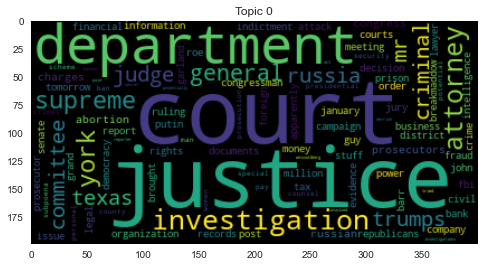

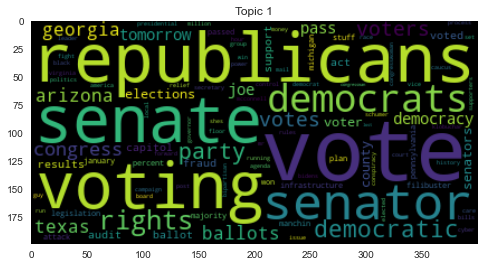

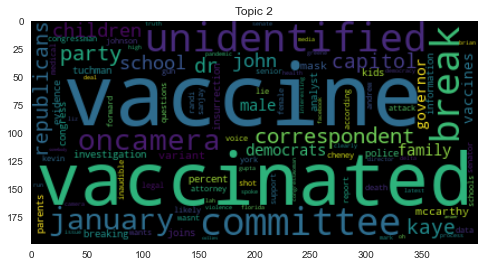

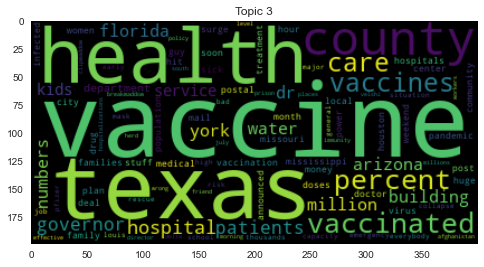

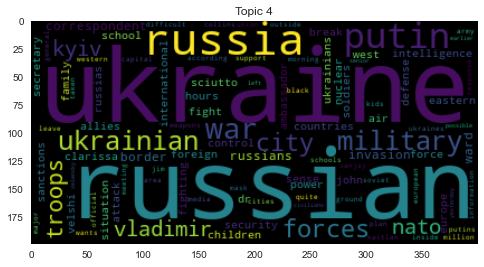

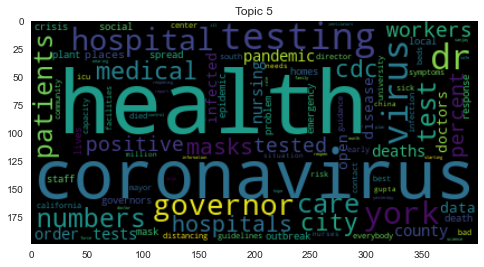

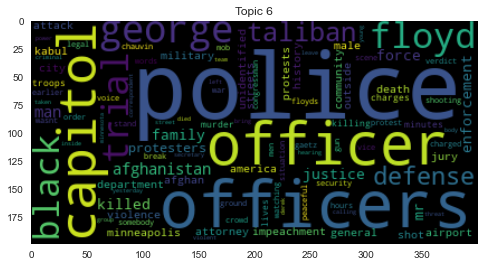

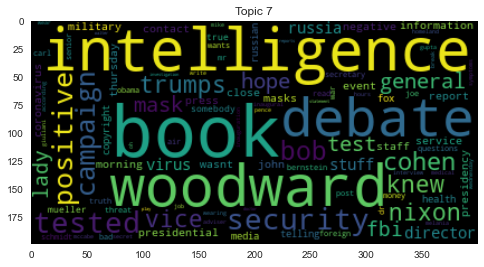

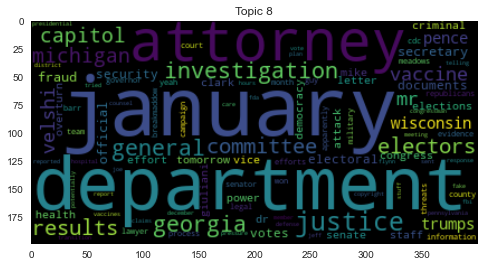

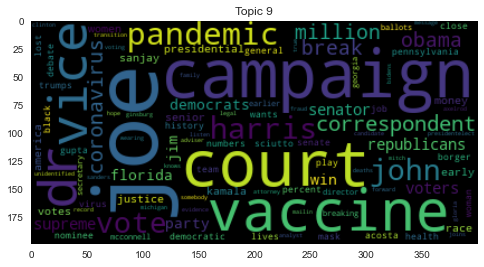

In [67]:
from wordcloud import WordCloud

for topic_idx in range(num_topics):
    wc = WordCloud(max_words = 100)
    wc.generate_from_frequencies(dict(zip(array_of_words_trans, topic_word_dist[topic_idx])))
    plt.figure()
    plt.imshow(wc, interpolation = 'bilinear')
    plt.title('Topic %d' % topic_idx)
    plt.grid(visible = None)

## Restricted Transcript Set - Nonzero COVID Mentions

In [68]:
%%time
# vary number of topics
for k in [9, 12, 15]:
    
    lda = LatentDirichletAllocation(n_components = k, 
                                    random_state = 0)

    lda.fit(X_transformed_trans_cov)
    
    topic_word_dist = np.array([row / row.sum() for row in lda.components_])
    
    print('-' * 50)
    print('Number of topics:', k)
    
    # list top 20 words in each topic
    for topic_idx in range(k):
        print('\n', 'Topic ', topic_idx, ':', sep = '')
        sort_idx = np.argsort(-topic_word_dist[topic_idx])
        for rank in range(20):
            word_idx = sort_idx[rank]
            print('{:<80} {:<10}'.format(array_of_words_trans[word_idx], topic_word_dist[topic_idx, word_idx]))

--------------------------------------------------
Number of topics: 9

Topic 0:
czar                                                                             0.008144639340775498
hug                                                                              0.008097937609512327
incident                                                                         0.007552580608769153
assertion                                                                        0.007403935559171519
illnesses                                                                        0.007192974541080461
broadcast                                                                        0.006717474108343029
felonies                                                                         0.006024913543714618
reaction                                                                         0.00447766973586808
claimed                                                                          0.004447916306976845
lo

--------------------------------------------------
Number of topics: 12

Topic 0:
broadcast                                                                        0.01371812808093777
illnesses                                                                        0.012527138792686035
reaction                                                                         0.007583577855867687
asking                                                                           0.006765394772203486
hug                                                                              0.005624483974885862
columbia                                                                         0.0053318834216139616
guidelines                                                                       0.005072894078498233
suppression                                                                      0.004587073435710644
dispatch                                                                         0.004484215872192775


--------------------------------------------------
Number of topics: 15

Topic 0:
broadcast                                                                        0.017275239179045637
reaction                                                                         0.008506260752632378
subpoenas                                                                        0.008504655402375908
illnesses                                                                        0.008379137095635755
asking                                                                           0.00741110577673319
guidelines                                                                       0.006977321393140099
columbia                                                                         0.006127631280363683
raskin                                                                           0.00477034532635428
success                                                                          0.004286012665128733
re

In [69]:
# fit with 15 topics
num_topics = 15

lda = LatentDirichletAllocation(n_components = num_topics, 
                                random_state = 0)

lda.fit(X_transformed_trans_cov)

LatentDirichletAllocation(n_components=15, random_state=0)

In [70]:
# normalize to get probability distributions
topic_word_dist = np.array([row / row.sum() for row in lda.components_])

In [71]:
# list top 20 words in each topic
for topic_idx in range(num_topics):
    print('\n', 'Topic ', topic_idx, ':', sep = '')
    sort_idx = np.argsort(-topic_word_dist[topic_idx])
    for rank in range(20):
        word_idx = sort_idx[rank]
        print('{:<80} {:<10}'.format(array_of_words_trans_cov[word_idx], topic_word_dist[topic_idx, word_idx]))


Topic 0:
capitol                                                                          0.017275239179045637
senate                                                                           0.008506260752632378
velshi                                                                           0.008504655402375908
january                                                                          0.008379137095635755
attack                                                                           0.00741110577673319
impeachment                                                                      0.006977321393140099
congress                                                                         0.006127631280363683
security                                                                         0.00477034532635428
vice                                                                             0.004286012665128733
senator                                                                   

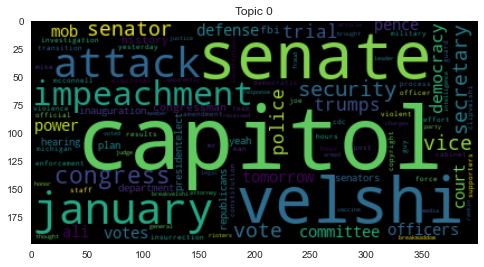

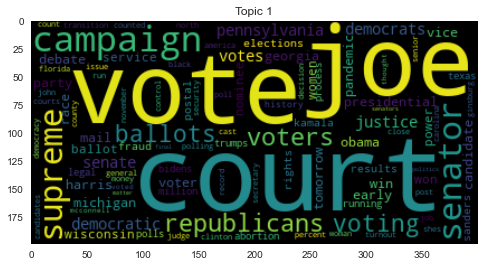

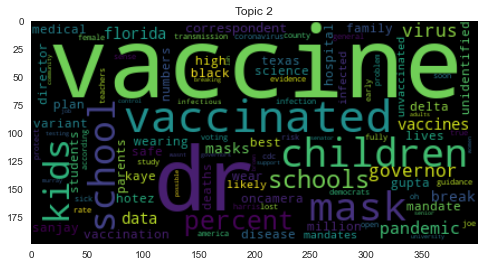

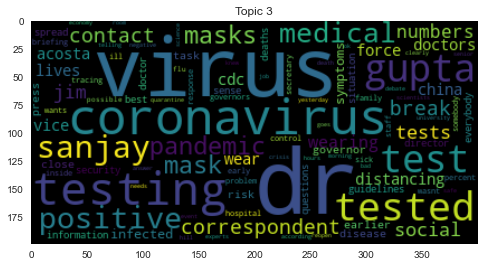

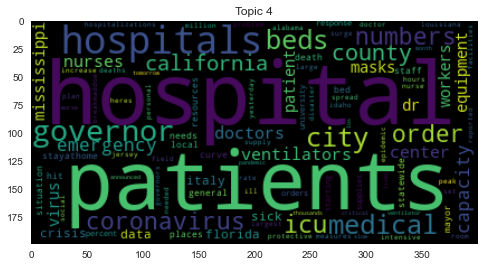

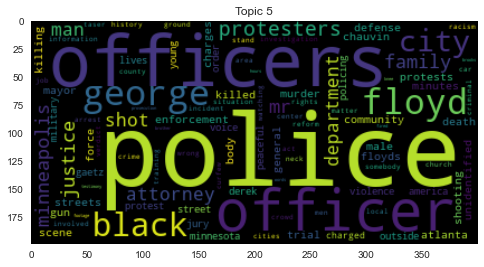

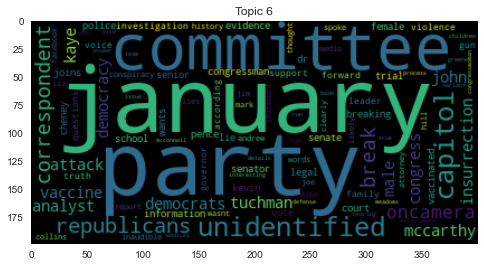

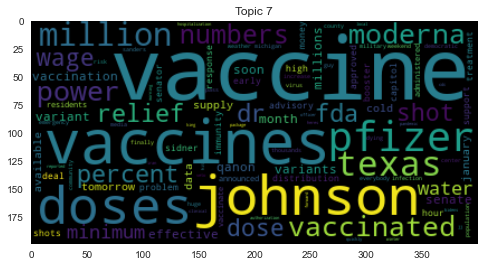

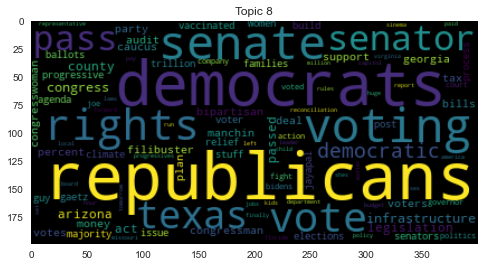

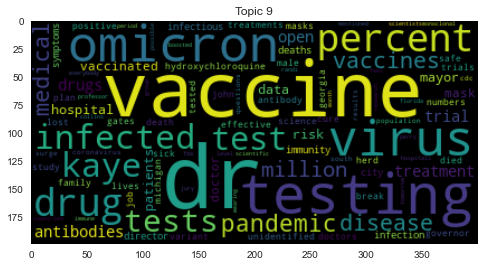

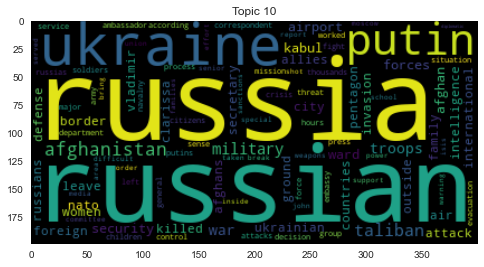

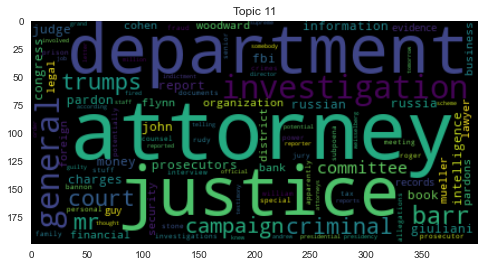

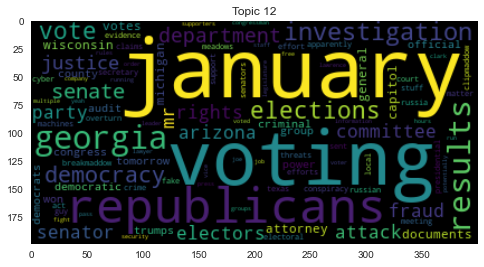

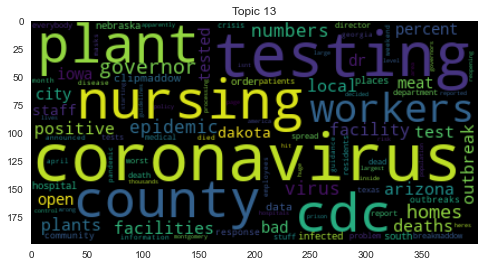

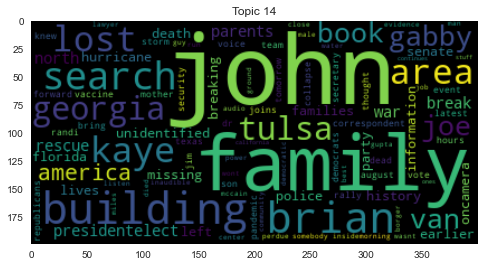

In [72]:
from wordcloud import WordCloud

for topic_idx in range(num_topics):
    wc = WordCloud(max_words = 100)
    wc.generate_from_frequencies(dict(zip(array_of_words_trans_cov, topic_word_dist[topic_idx])))
    plt.figure()
    plt.imshow(wc, interpolation = 'bilinear')
    plt.title('Topic %d' % topic_idx)
    plt.grid(visible = None)

Ideas:
1. We're really focused on **co-occurrences** with words like vaccines, covid etc. It could be helpful to try to use the results from LDA to extract just the topics related to covid and see what the co-occurring words are for those topics?

## Sentiment Analysis

pmi -- (lemma, co-occurence)
Should we just look at the sentiment of the co-occuring words?

Soruce for sentiment analysis work = 
Need to use the raw_text, string of strings for this analysis

Keep in mind that VADER is likely better at rating tweets than it is at rating long movie reviews. To get better results, you’ll set up VADER to rate individual sentences within the review rather than the entire text.

Will use the VADER method = NLTK already has a built-in, pretrained sentiment analyzer called VADER (Valence Aware Dictionary and sEntiment Reasoner).

Source: https://realpython.com/python-nltk-sentiment-analysis/

### Step 1: Convert List of 1 String Per Transcript to A List of Strings of **All of the Sentences** In the Dataset

Here we split each of the text files on "." - which we are using to incidate different sentences

In [ ]:
transcript_sentences = [text.split(".") for text in raw_text]

#collapse the sentences togehter so instead of a list of lists (with each sublist = 1 transcript, we get all of the sentences across all of the transcripts)
flattened_transcripts_sentences = [sentence for single_transcript in transcript_sentences for sentence in single_transcript]


print( "There are {:,} sentences acrosss the {:,} transcripts in the liberal corpus.".format(len(flattened_transcripts_sentences), len(transcript_sentences)))

### Step 2: Subset the List of Sentences That Include COVID Terms + The Top 100 Co-Occcurring Words

The goal here is to better understand the context/sentiment around how covid is discussed in the liberal corpus. 

In [ ]:
# top_100_pmi_words = pmi_sort[:100]

# top_100_pmi_words_dict = dict(top_100_pmi_words)

# total_covid_words = covid_terms + list(top_100_pmi_words_dict.keys())

# print(total_covid_words)



#For now, until we can do some better string cleaning, I will just be including covid-terms
covid_sentences = [sentence for sentence in flattened_transcripts_sentences if any(word in sentence for word in covid_terms)]

print("There are {:,} sentences across the corpus that mention one of the covid-related terms.".format(len(covid_sentences)))


### Step 3: Determine the Sentiment of Each of the Sentences


In [ ]:
#to run the code chunk below, you may need to run the following lines:
#import nltk
# import ssl

# try: #attempt to address SSL issues that come up
#     _create_unverified_https_context = ssl._create_unverified_context
# except AttributeError:
#     pass
# else:
#     ssl._create_default_https_context = _create_unverified_https_context 

#nltk.download('vader_lexicon')


In [ ]:
#import the required packages
from nltk.sentiment import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()


In [ ]:
#test the package
sia.polarity_scores("Wow, NLTK is really powerful!")

In [ ]:
#try the sentiment analysis on the covid_sentences

#store all of the compound scores
total_compound_scores = []
positive_setences = []
negative_sentences = []
neutral_sentences = []
#first 5 sentences test
for sentence in covid_sentences:
    score = sia.polarity_scores(sentence)
    compound_score = score["compound"]
    total_compound_scores.append(compound_score)

    if compound_score == 0:
        neutral_sentences.append((sentence, score))
    elif compound_score > 0:
        positive_setences.append((sentence, score))
    else: 
        negative_sentences.append((sentence, score))

print("The mean compound sentiment score is: {}".format(sum(total_compound_scores)/len(total_compound_scores)))
print("There are {:,} positive sentences, {:,} neutral sentences, {:,} and negative sentences.".format(len(positive_setences), len(neutral_sentences), len(negative_sentences)))

## Plot the Sentiment Distribution

In [ ]:
plt.style.use('seaborn')  

x = ["positive", "neutral", "negative"]
y = [len(positive_setences), len(neutral_sentences), len(negative_sentences)]
plt.bar(x,y)
plt.xlabel('Sentiment')
plt.xticks(rotation=45)
plt.ylabel('Number of Setences')
plt.title('Distribution of Sentiment in Liberal Corpus')

plt.show()

### Top 10 Positive Sentences


In [ ]:
positive_sentences_sort = sorted(positive_setences, key = lambda x: x[1]["pos"], reverse = True)


top_10_positive_sentences = positive_sentences_sort[:10]

for idx, combo in enumerate(top_10_positive_sentences):
    sentence, score = combo #deconstruct the sentence, score combo
    print("{}. {} \n Percent Positive: {:.1%} \n Percent Neutral: {:.1%} \n Percent Negative: {:.1%} \n".format(idx+1, sentence, score["pos"], score["neu"], score["neg"]))



## Top 10 Negative Sentences

In [ ]:
negative_sentences_sort = sorted(negative_sentences, key = lambda x: x[1]["neg"], reverse = True)


top_10_negative_sentences = negative_sentences_sort[:10]

for idx, combo in enumerate(top_10_negative_sentences):
    sentence, score = combo #deconstruct the sentence, score combo
    print("{}. {} \n Percent Negative: {:.1%}  \n Percent Neutral: {:.1%} \n  Percent Positive: {:.1%}\n".format(idx+1, sentence, score["neg"], score["neu"], score["pos"]))


To-do :
* could do some additional work/topic LDA analysis on the negative/positive sentences to see how, even if the sentiment is negative, the nature of the negative 
* sentiment is different across conservative versus liberal corpuses

#### Examine How Vaccinations Are Generally Talked About
- perhaps we also do some PMI analysis with the word "vaccine" and "masks" as well

In [ ]:
vaccine_terms = ["vaccine", "jab", "vaccinations", "vaccination", "moderna", "pfizer", "j&j", "johnson&johnson"]
vaccine_sentences = [sentence for sentence in flattened_transcripts_sentences if any(word in sentence for word in vaccine_terms)]

print("There are {} sentences in the {} transcripts about vaccines.".format(len(vaccine_sentences), len(transcript_sentences)))